In [459]:
import os

import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.table import Table
from astropy.io import fits
from astropy import nddata

from astropy import constants as cnst

from astropy import visualization

import ccdproc

first = lambda x:next(iter(x))

%matplotlib inline
from matplotlib import style, pyplot as plt

# Helpers 

In [72]:
def imshow_vis(data, interval=visualization.PercentileInterval(99), 
                    stretch=visualization.LogStretch(),
               **kwargs):
    return plt.imshow(data, norm=visualization.ImageNormalize(data, interval, stretch=stretch), **kwargs)

In [353]:
#from https://github.com/ebellm/pyraf-dbsp/blob/master/dbsp.py

def calculate_dispersion(grating, angle, side='blue', order=1):
    """Calculate parameters needed to initialize dispersion solution.
    Modifies global variable det_pars with the computed values.
    See http://www.astro.caltech.edu/palomar/200inch/dbl_spec/dbspoverview.html
    for details.
    Parameters
    ----------
    grating : integer
        grating lines/mm
    angle : float
        grating angle in degrees
    side : {'blue' (default), 'red'}
        'blue' or 'red' to indicate the arm of the spectrograph
    order : int (default = 1)
        Spectral order
    Returns
    -------
    central_wavelength : float
        central wavelength in Angstroms
    dispersion : float
        dispersion in Angstroms / mm
    """

    MM_TO_ANGSTROM = 10000000
    INCHES_TO_MM = 25.4
    diffracted_angle = {'red':35.00, 'blue':38.50} # degrees
    focal_length = {'red':12.*INCHES_TO_MM, 'blue':9.*INCHES_TO_MM}

    line_spacing = 1./grating # mm

    theta_m = diffracted_angle[side] - angle
    central_wavelength = order * np.abs((np.sin(np.radians(theta_m)) - 
        np.sin(np.radians(angle))) * line_spacing * MM_TO_ANGSTROM) # Angstrom

    dispersion = (line_spacing * np.cos(np.radians(theta_m)) / 
        (focal_length[side] * order)) * MM_TO_ANGSTROM 

    return central_wavelength, dispersion

def image_dispersion_params(im, side):
    linesmm = float(im.header['GRATING'].split('/')[0])
    grangle = Angle(redarc.header['ANGLE'])
    cen, disp = calculate_dispersion(linesmm, grangle.deg, side)
    disp = disp*u.angstrom/u.mm
    if side == 'red':
        pixel_size = 15*u.micron/u.pixel
    elif side == 'blue':
        pixel_size = 15*u.micron/u.pixel
    else:
        raise ValueError('unrecognized side')
    
    return cen*u.angstrom, (disp*pixel_size).to(u.angstrom/u.pixel)

In [368]:
def process_image(n, red, bias=None):
    if red:
        fn = red_fn(n)
    else:
        fn = blue_fn(n)
    im = ccdproc.CCDData.read(fn, unit=u.adu)
    h = im.header
    data = im*(h['GAIN']*u.electron/u.adu)
    im = ccdproc.CCDData(data, uncertainty=nddata.StdDevUncertainty(data.value**0.5),  header=h)
    im.meta = h
    imsub = ccdproc.subtract_overscan(im, fits_section=im.header['BSEC1'], overscan_axis=1)
    imtrim = ccdproc.trim_image(imsub, fits_section=im.header['TSEC1'])
    if bias is None:
        return imtrim
    else:
        return ccdproc.subtract_bias(imtrim, bias)

# Load data 

In [9]:
base_fn = os.path.abspath('./dbsp_jul2018/')

blue_fn = lambda num:  os.path.join(base_fn, 'blue{:04}.fits'.format(num))
red_fn = lambda num:  os.path.join(base_fn, 'red{:04}.fits'.format(num))

In [18]:
bias_nums = np.arange(10) + 1
fear_nums = np.arange(5) + 16
henear_nums = np.arange(5) + 11
flat_nums = np.arange(10) + 31

In [17]:
data_nums = np.arange(3) + 59
arcs_nums = [62]  # *on sky* arcs

In [ ]:
lines = {}
with open('henear.dat', 'r') as f:
    for line in f:
        if line.lstrip().startswith('#') or line.strip() == '':
            continue
        
        spl = line.split()
        wl = float(spl[0])
        lines[wl] = spl[1]

In [310]:
red_biases = [process_image(n, True) for n in bias_nums]
blue_biases = [process_image(n, False) for n in bias_nums]

red_bias = ccdproc.combine(red_biases, method='median')
blue_bias = ccdproc.combine(blue_biases, method='median')

# Arcs

/Users/erik/miniconda3/envs/astro36/lib/python3.6/site-packages/astropy/visualization/stretch.py:264: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/Users/erik/miniconda3/envs/astro36/lib/python3.6/site-packages/matplotlib/colors.py:493: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


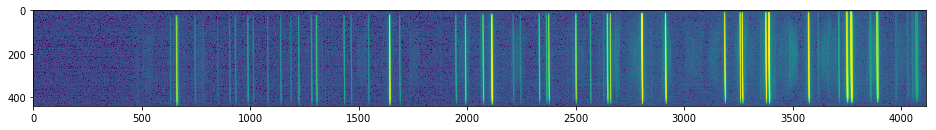

In [370]:
redarc = process_image(arcs_nums[0], True, red_bias)

plt.figure(figsize=(16, 4))
imshow_vis(redarc)

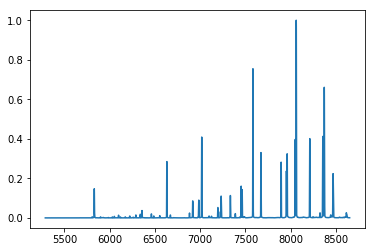

In [382]:
arclines = np.median(redarc, axis=0)
arclines /= np.max(arclines)

cen, disp = image_dispersion_params(redarc, 'red')
dx = (np.arange(redarc.shape[1]) - redarc.shape[1]/2) * u.pixel
wl_guess = (cen + disp*dx)
plt.plot(wl_guess, arclines)

In [380]:
lines = np.array([wl for wl in lines.keys() if wl < wl_guess[-1].value and wl > wl_guess[0].value])

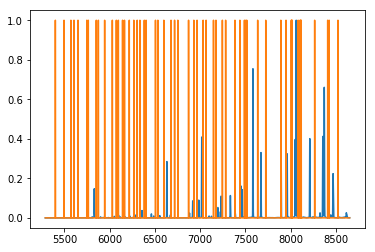

In [390]:
fake_arc = np.zeros_like(arclines)
fake_arc[np.searchsorted(wl_guess.value, lines)] = 1
plt.plot(wl_guess, arclines)
plt.plot(wl_guess, fake_arc)

64.66476979276544

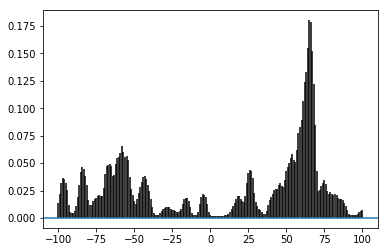

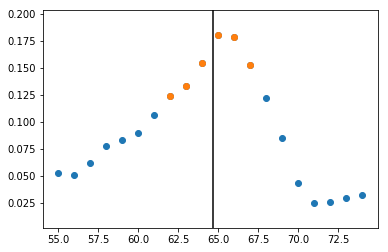

In [445]:
lag, xc, _, _ = plt.xcorr(fake_arc, arclines, maxlags=100)
peaki = np.argmax(xc)

plt.figure()
sl1 = slice(peaki-10, peaki+10)
sl2 = slice(peaki-3, peaki+3)
plt.scatter(lag[sl1], xc[sl1])
plt.scatter(lag[sl2], xc[sl2])
peaklag = np.sum(xc[sl2]*lag[sl2]/np.sum(xc[sl2]))
plt.axvline(peaklag, color='k')
peaklag

2768.933785587345

(2851.0951281554267, 2997.921240516273)

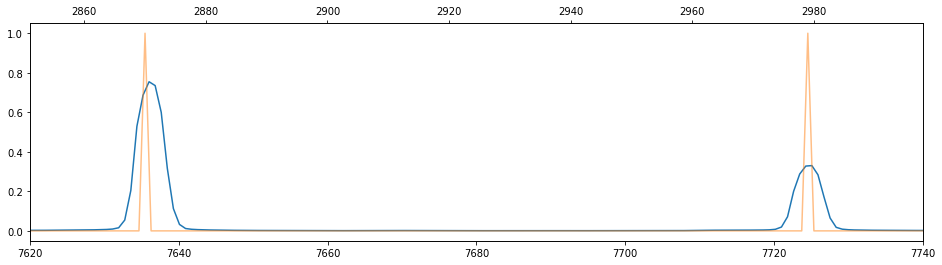

In [542]:
better_wl = wl_guess + (peaklag*u.pixel)*disp

plt.figure(figsize=(16, 4))
plt.plot(better_wl, arclines)
plt.plot(wl_guess, fake_arc, alpha=.5)
xl, xu = plt.xlim(7620, 7740)
plt.twiny()
plt.xlim(np.interp(xl,wl_guess,np.arange(len(better_wl))),
         np.interp(xu,wl_guess,np.arange(len(better_wl))))

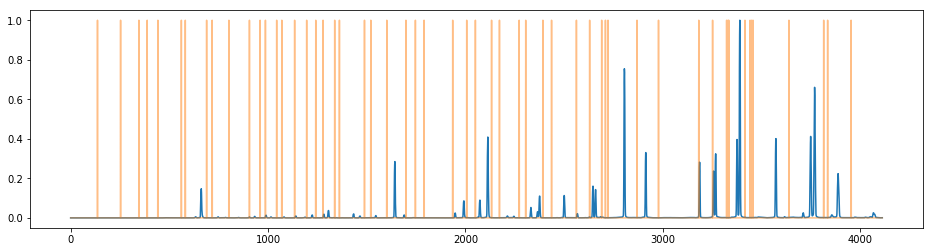

In [526]:
plt.figure(figsize=(16, 4))
plt.plot(arclines)
plt.plot(fake_arc, alpha=.5)

In [1]:
!open .

In [579]:
import dispersion

soln = dispersion.DispersionSolution(arclines, poly_order=3)

In [580]:
soln.guess_line_loc(2805, 7635.105)
soln.guess_line_loc(2915, 7723.8)

(2914.2551596203507, 7723.8)

 [astropy.modeling.fitting]


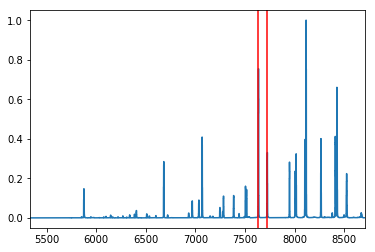

In [581]:
soln.plot_spec_wl()

In [582]:
soln.guess_from_line_list('henear.dat')

 [astropy.modeling.fitting]


Failed to find line HeI at wl=3187.743: "requested peak location is not in the spectrum"
Failed to find line AII(70) at wl=3464.14: "requested peak location is not in the spectrum"
Failed to find line NeI at wl=3520.5: "requested peak location is not in the spectrum"
Failed to find line AII(70) at wl=3545.58: "requested peak location is not in the spectrum"
Failed to find line AII(70) at wl=3559.51: "requested peak location is not in the spectrum"
Failed to find line AII(131) at wl=3718.21: "requested peak location is not in the spectrum"
Failed to find line AII(10) at wl=3729.29: "requested peak location is not in the spectrum"
Failed to find line AII(131) at wl=3737.89: "requested peak location is not in the spectrum"
Failed to find line AII(54) at wl=3780.84: "requested peak location is not in the spectrum"
Failed to find line AII(10) at wl=3850.57: "requested peak location is not in the spectrum"
Failed to find line HeI at wl=3888.646: "requested peak location is not in the spectru

(41, 51)

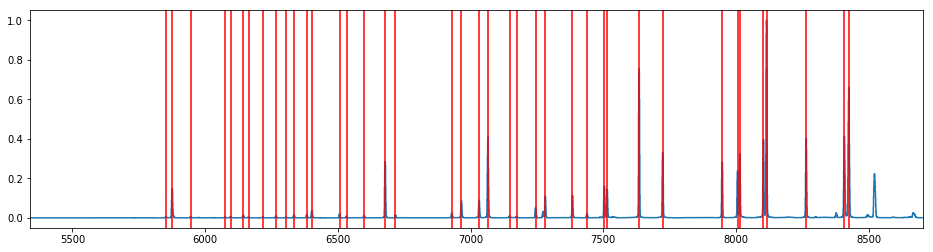

In [583]:
plt.figure(figsize=(16, 4))
soln.plot_spec_wl()

(1500, 2000)

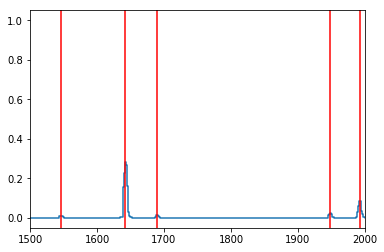

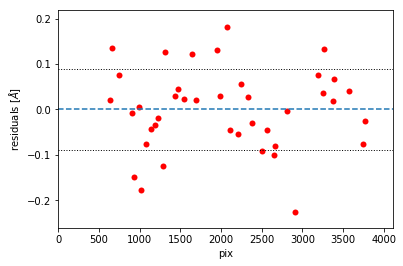

In [584]:
soln.plot_solution(residuals=True)

In [587]:
ha = soln.wltopix(6563*(1+((257*u.km/u.s)/cnst.c)))
ha

<Quantity 1509.11082533>

In [593]:
(soln.pixtowl(1517)/6563 - 1)*cnst.c.to(u.km/u.s)

<Quantity 552.72316522 km / s>

/Users/erik/miniconda3/envs/astro36/lib/python3.6/site-packages/astropy/visualization/stretch.py:264: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/Users/erik/miniconda3/envs/astro36/lib/python3.6/site-packages/matplotlib/colors.py:493: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


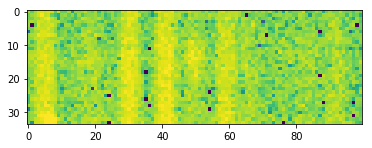

In [656]:
imshow_vis(process_image(data_nums[0], True, red_bias)[24:58, 1460:1560])

Failed to find line HeI at wl=3187.743: "requested peak location is not in the spectrum"
Failed to find line AII(70) at wl=3464.14: "requested peak location is not in the spectrum"
Failed to find line NeI at wl=3520.5: "requested peak location is not in the spectrum"
Failed to find line AII(70) at wl=3545.58: "requested peak location is not in the spectrum"
Failed to find line AII(70) at wl=3559.51: "requested peak location is not in the spectrum"
Failed to find line AII(131) at wl=3718.21: "requested peak location is not in the spectrum"
Failed to find line AII(10) at wl=3729.29: "requested peak location is not in the spectrum"
Failed to find line AII(131) at wl=3737.89: "requested peak location is not in the spectrum"
Failed to find line AII(54) at wl=3780.84: "requested peak location is not in the spectrum"
Failed to find line AII(10) at wl=3850.57: "requested peak location is not in the spectrum"
Failed to find line HeI at wl=3888.646: "requested peak location is not in the spectru

(28, 64)

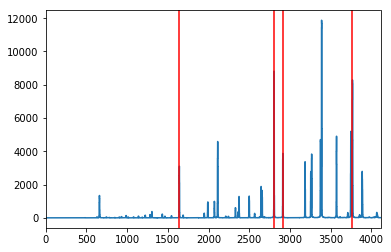

In [651]:
solnlow = dispersion.DispersionSolution(np.average(redarc[24:58], axis=0), poly_order=3)

solnlow.guess_line_loc(2805, 7635.105)
solnlow.guess_line_loc(2915, 7723.8)
solnlow.guess_line_loc(1642, 6678.2)
solnlow.guess_line_loc(3770, 8424.647)

solnlow.plot_spec()
solnlow.guess_from_line_list('henear.dat')

In [657]:
(solnlow.pixtowl(1517)/6563 - 1)*cnst.c.to(u.km/u.s)

<Quantity 536.19943671 km / s>